# Implementation of Magic Window Logic

### Predicting the percentage change from the current open price to some open price in the future from the previous year of open, high, low, and close prices as well as the volume

In [19]:
import numpy as np
from datetime import datetime, timedelta
import pywt
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.optimizers import Adam
from keras import metrics
from keras import backend as K
from attention import Attention
import keras.utils.vis_utils
from importlib import reload
reload(keras.utils.vis_utils)
from keras.utils.vis_utils import plot_model
plt.style.use('seaborn')

In [20]:
ticker = '^GSPC'
exposureSize = 128
lookAhead = 1
numEpochs = 12
batchSize = 32

(5690,)
(5690,)
(5690,)
(5690,)
(5690,)
(5690, 5)


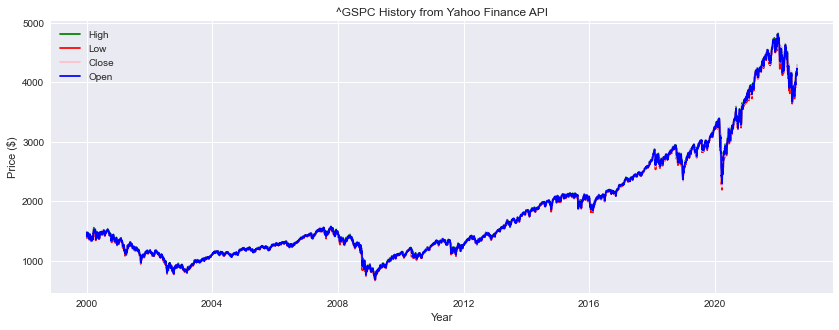

In [21]:
target = yf.Ticker(ticker)
today = datetime.now().date().strftime("%Y-%m-%d")
history = target.history(start="2000-01-01", end=today)
opens = history.Open
highs = history.High
lows = history.Low
closes = history.Close
volume = history.Volume
data = pd.concat([opens, highs, lows, closes, volume], axis=1)
data.dropna(inplace=True, axis=0)

print(opens.shape)
print(highs.shape)
print(lows.shape)
print(closes.shape)
print(volume.shape)
print(data.shape)

plt.figure(figsize=(14, 5))
plt.plot(highs, color='green', label='High')
plt.plot(lows, color='red', label='Low')
plt.plot(closes, color='pink', label='Close')
plt.plot(opens, color='blue', label='Open')
historyPlotTitle = ticker + ' History from Yahoo Finance API'
plt.title(historyPlotTitle)
plt.xlabel('Year')
plt.ylabel('Price ($)')
plt.legend()
plt.show()

In [22]:
nulls = data.isnull().sum().sum() + data.isna().sum().sum()
if (nulls == 0):
    print('Dataset is clean!')
else:
    print('Dataset is unclean!')

Dataset is clean!


In [23]:
trainingDataUnscaled, testingDataUnscaledPreContext = train_test_split(data, test_size=0.1, random_state=42, shuffle=False)
splitDate = testingDataUnscaledPreContext.index[0].date()
previousDays = trainingDataUnscaled.tail(exposureSize)
testingDataUnscaled = pd.concat([previousDays, testingDataUnscaledPreContext], axis=0)

print(splitDate)
print(trainingDataUnscaled.shape)
print(testingDataUnscaled.shape)

2020-05-12
(5121, 5)
(697, 5)


In [24]:
scaler = StandardScaler()
anotherScaler = MinMaxScaler()

trainingDataStandardised = scaler.fit_transform(trainingDataUnscaled)
trainingData = anotherScaler.fit_transform(trainingDataStandardised)

testingDataStandardised = scaler.transform(testingDataUnscaled)
testingData = anotherScaler.transform(testingDataStandardised)

In [25]:
def WaveletTransform(data, levels, threshold=0.63, wavelet='coif3'):
    reconstructedData = pd.DataFrame()
    for i in range(data.shape[1]):
        threshold = threshold * np.nanmax(data[:,i])
        coefficients = pywt.wavedec(data[:,i], wavelet, mode='per', level=levels)
        coefficients[1:] = (pywt.threshold(i, value=threshold, mode='soft') for i in coefficients[1:])
        reconstructedColumn = pywt.waverec(coefficients, wavelet, mode='per')
        reconstructedData = pd.concat([reconstructedData, pd.DataFrame(reconstructedColumn)], axis=1)
    return reconstructedData

# trainingDataUncut = np.array(WaveletTransform(trainingDataNormalised, 3))
# trainingData = trainingDataUncut[7:-7,:]

In [26]:
X_train = []
y_train = []

for i in range(exposureSize, trainingData.shape[0]-lookAhead):
    X_train.append(trainingData[i-exposureSize:i])
    y_train.append(((trainingDataUnscaled.iloc[i+lookAhead, 0]-trainingDataUnscaled.iloc[i, 0])/trainingDataUnscaled.iloc[i, 0])*100)

X_train, y_train = np.array(X_train), np.array(y_train)

print(X_train.shape)
print(y_train.shape)

(4992, 128, 5)
(4992,)


In [27]:
X_test = []
y_test = []

for i in range(exposureSize, testingData.shape[0]-lookAhead):
    X_test.append(testingData[i-exposureSize:i])
    y_test.append(((testingDataUnscaled.iloc[i+lookAhead, 0]-testingDataUnscaled.iloc[i, 0])/testingDataUnscaled.iloc[i, 0])*100)

X_test, y_test = np.array(X_test), np.array(y_test)

print(X_test.shape)
print(y_test.shape)

(568, 128, 5)
(568,)


In [28]:
# REF: https://jmlb.github.io/ml/2017/03/20/CoeffDetermination_CustomMetric4Keras/
def coefficient_of_determination(y_true, y_pred):
    SS_res = K.sum(K.square(y_true-y_pred)) 
    SS_tot = K.sum(K.square(y_true-K.mean(y_true))) 
    return (1 - SS_res/(SS_tot+K.epsilon()))

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 128, 50)           11200     
                                                                 
 lstm_3 (LSTM)               (None, 128, 50)           20200     
                                                                 
 attention_1 (Attention)     (None, 16)                4100      
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 35,517
Trainable params: 35,517
Non-trainable params: 0
_________________________________________________________________
None


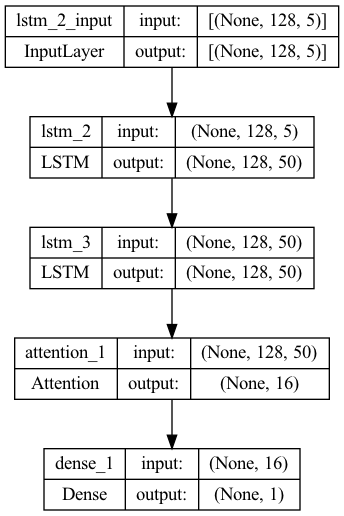

In [29]:
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(LSTM(50, return_sequences=True))
model.add(Attention(units=16))
model.add(Dense(1))
optimiser = Adam(learning_rate=0.01)
model.compile(loss='mae', optimizer=optimiser, metrics=[metrics.MeanAbsoluteError(), metrics.MeanSquaredError(), metrics.RootMeanSquaredError(), coefficient_of_determination])
print(model.summary())
plot_model(model, to_file='./MagicWindowModelTwo.png', show_shapes=True)

In [30]:
model.fit(X_train, y_train, epochs=numEpochs//3, batch_size=batchSize, validation_data=(X_test, y_test), verbose=1)
K.set_value(model.optimizer.learning_rate, 0.001)
model.fit(X_train, y_train, epochs=numEpochs//3, batch_size=batchSize, validation_data=(X_test, y_test), verbose=1)
K.set_value(model.optimizer.learning_rate, 0.0001)
history = model.fit(X_train, y_train, epochs=numEpochs//3, batch_size=batchSize, validation_data=(X_test, y_test), verbose=1)

Epoch 1/4


2022-08-13 15:50:23.935612: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "110" frequency: 2400 num_cores: 16 environment { key: "cpu_instruction_set" value: "SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 262144 l3_cache_size: 16777216 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


155/156 [============================>.] - ETA: 0s - loss: 0.7699 - mean_absolute_error: 0.7699 - mean_squared_error: 1.3407 - root_mean_squared_error: 1.1579 - coefficient_of_determination: -0.0529

2022-08-13 15:50:32.765624: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "110" frequency: 2400 num_cores: 16 environment { key: "cpu_instruction_set" value: "SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 262144 l3_cache_size: 16777216 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


156/156 [==============================] - 12s 56ms/step - loss: 0.7710 - mean_absolute_error: 0.7710 - mean_squared_error: 1.3486 - root_mean_squared_error: 1.1613 - coefficient_of_determination: -0.0527 - val_loss: 0.8047 - val_mean_absolute_error: 0.8047 - val_mean_squared_error: 1.1761 - val_root_mean_squared_error: 1.0845 - val_coefficient_of_determination: -0.0442
Epoch 2/4
156/156 [==============================] - 8s 52ms/step - loss: 0.7651 - mean_absolute_error: 0.7651 - mean_squared_error: 1.3366 - root_mean_squared_error: 1.1561 - coefficient_of_determination: -0.0355 - val_loss: 0.7968 - val_mean_absolute_error: 0.7968 - val_mean_squared_error: 1.1713 - val_root_mean_squared_error: 1.0823 - val_coefficient_of_determination: -0.0309
Epoch 3/4
156/156 [==============================] - 8s 52ms/step - loss: 0.7652 - mean_absolute_error: 0.7652 - mean_squared_error: 1.3374 - root_mean_squared_error: 1.1565 - coefficient_of_determination: -0.0379 - val_loss: 0.7976 - val_mean_a

In [31]:
y_hat = model.predict(X_test)

2022-08-13 15:52:07.736464: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "110" frequency: 2400 num_cores: 16 environment { key: "cpu_instruction_set" value: "SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 262144 l3_cache_size: 16777216 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


18/18 [==============================] - 1s 21ms/step


In [32]:
# # Undo normalisation
# y_test = (y_test * anotherScaler.data_range_[0]) + anotherScaler.data_min_[0]
# y_hat = (y_hat * anotherScaler.data_range_[0]) + anotherScaler.data_min_[0]

# # Undo standardisation
# y_test = (y_test * scaler.scale_[0]) + scaler.mean_[0]
# y_hat = (y_hat * scaler.scale_[0]) + scaler.mean_[0]
print(y_hat.flatten()[0:5])
print(y_test[0:5])

[0.08808995 0.08805139 0.08807609 0.08815852 0.08821888]
[-2.5051843  -2.48860955  1.26711057  2.96507563  1.19188908]


In [33]:
actualChange = []
for i in range(exposureSize, testingDataUnscaled.shape[0]-lookAhead):
    actualChange.append(((testingDataUnscaled.iloc[i+lookAhead, 0]-testingDataUnscaled.iloc[i, 0])/testingDataUnscaled.iloc[i, 0])*100)

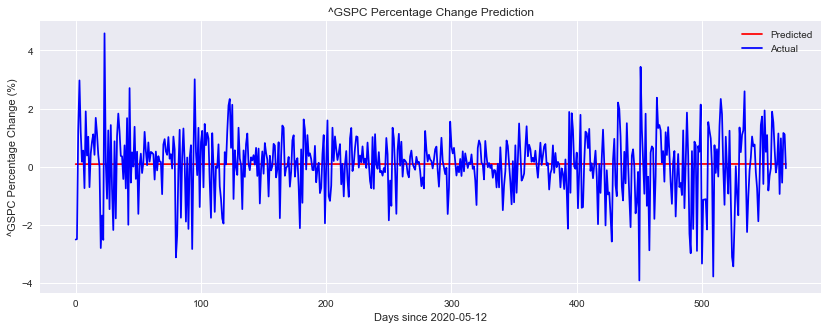

In [34]:
predictionPlotTitle = ticker + " Percentage Change Prediction"
xLabel = "Days since " + splitDate.strftime("%Y-%m-%d")
yLabel = ticker + " Percentage Change (%)"

plt.figure(figsize=(14, 5))
plt.plot(y_hat, color='red', label="Predicted")
plt.plot(y_test, color='blue', label="Actual")
# plt.plot(actualChange, color='green', label="Actual Change")
plt.title(predictionPlotTitle)
plt.xlabel(xLabel)
plt.ylabel(yLabel)
plt.legend()
plt.show()

In [35]:
mae = history.history['mean_absolute_error']
mse = history.history['mean_squared_error']
rmse = history.history['root_mean_squared_error']
r2 = history.history['coefficient_of_determination']

print('Mean Absolute Error (MAE): ' + str(mae[-1]))
print('Mean Squared Error (MSE): ' + str(mse[-1]))
print('Root Mean Squared Error (RMSE): ' + str(rmse[-1]))
print('Coefficient of Determination (R2): ' + str(r2[-1]))

Mean Absolute Error (MAE): 0.7641918659210205
Mean Squared Error (MSE): 1.336544156074524
Root Mean Squared Error (RMSE): 1.1560900211334229
Coefficient of Determination (R2): -0.03489119932055473


In [36]:
print(round(mae[-1], ndigits=5))
print(round(mse[-1], ndigits=5))
print(round(rmse[-1], ndigits=5))
print(round(r2[-1], ndigits=5))

0.76419
1.33654
1.15609
-0.03489


Without preprocessing outputs:
Mean Absolute Error (MAE): 0.007744188886135817
Mean Squared Error (MSE): 0.0001417080347891897
Root Mean Squared Error (RMSE): 0.011904118582606316
Coefficient of Determination (R2): -0.023085584864020348

With preprocessing outputs:
